In [1]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
import nltk
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df = pd.read_csv('../data/preprocessed_train.csv', encoding='utf-8')
df.head()

,title,author,text,label,removed_punc,tokens,filtered_tokens,clean_tokens,lemma_words,clean_text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide We Didn’t Even See Comey’s Lett...,"['house', 'dem', 'aide', 'we', 'didn’t', 'even...","['house', 'aide', 'didn’t', 'even', 'comey’s',...","['house', 'aide', 'didn’t', 'even', 'comey’s',...","['house', 'aide', 'didn’t', 'even', 'comey’s',...",house aide didn’t even comey’s letter jason ch...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,Ever get the feeling your life circles the rou...,"['ever', 'get', 'the', 'feeling', 'your', 'lif...","['ever', 'feeling', 'your', 'life', 'circles',...","['ever', 'feeling', 'life', 'circles', 'rounda...","['ever', 'feeling', 'life', 'circle', 'roundab...",ever feeling life circle roundabout rather hea...
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired October 29 2...,"['why', 'the', 'truth', 'might', 'get', 'you',...","['truth', 'might', 'fired', 'october', '2016',...","['truth', 'might', 'fired', 'october', '2016',...","['truth', 'might', 'fired', 'october', '2016',...",truth might fired october 2016 tension intelli...
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,Videos 15 Civilians Killed In Single US Airstr...,"['videos', '15', 'civilians', 'killed', 'in', ...","['videos', 'civilians', 'killed', 'single', 'a...","['videos', 'civilians', 'killed', 'single', 'a...","['video', 'civilian', 'killed', 'single', 'air...",video civilian killed single airstrike identif...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Print \nAn Iranian woman has been sentenced to...,"['print', 'an', 'iranian', 'woman', 'has', 'be...","['print', 'iranian', 'woman', 'been', 'sentenc...","['print', 'iranian', 'woman', 'sentenced', 'ye...","['print', 'iranian', 'woman', 'sentenced', 'ye...",print iranian woman sentenced year prison iran...


In [3]:
# Cargamos el dataset en una variable que se llama data
# Es simplemente una lista de strings. Cada string un texto

# List of sentences
data = df.loc[df['label'] == 1, 'clean_text'] #0: real y 1: fake. reemplazar por la columna deseada del dataset

# Crear los sets para calculasr los sesgos
# Las listas tipo A y B son palabras de dos campos semanticos contrastantes
# Las listas tipo C son palabras objetivos
A_man = ["he", "son", "his", "him", "father", "man", "boy", "himself", "male",
         "brother", "sons", "fathers", "men", "boys", "males", "brothers",
         "uncle", "uncles", "nephew", "nephews"]
B_woman = [
          "she", "daughter", "hers", "her", "mother", "woman", "girl",
           "herself", "female", "sister", "daughters", "mothers", "women",
           "girls", "females", "sisters", "aunt", "aunts", "niece",
           "nieces"
           ]

C_personality = [
    "devious", "bizarre", "venomous", "erratic", "barbaric", "frightening", "deceitful",
    "forceful", "deceptive", "envious", "greedy", "hateful", "contemptible", "brutal", "monstrous", "calculating",
    "cruel", "intolerant", "aggressive", "monstrous"
]

C_appearence = [
    "alluring", "voluptuous", "blushing", "homely", "plump", "sensual", "gorgeous", "slim", "bald", "athletic",
    "fashionable", "stout", "ugly", "muscular", "slender", "feeble", "handsome", "healthy", "attractive", "fat",
    "weak", "thin", "pretty", "beautiful", "strong"
]

AS = [A_man, A_man]
BS = [B_woman, B_woman]
CS = [C_personality, C_appearence]

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

# Defininmos el corpus a usar
texts = data.tolist()

texts = [text for text in texts if not (isinstance(text, float) and np.isnan(text))]

# Tokenizamos los textos
tokenized_texts = [word_tokenize(text.lower()) for text in texts]

# Removemos las stop words y la puntuacion
stop_words = set(stopwords.words('english'))
tokenized_texts = [
    [word for word in tokens if word.isalnum() and word not in stop_words]
    for tokens in tokenized_texts
]

# Definimos el modelo Word2Vec
model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

# Lo entrenamos
model.train(tokenized_texts, total_examples=len(tokenized_texts), epochs=10)

# Accedemos a los embeddings
word_embeddings = model.wv

# Lista de las palabras procesadas
all_words = word_embeddings.key_to_index.keys()

[nltk_data] Downloading package punkt to /home/viti/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/viti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def get_bias_df_from_ABC(A, B, C):
  # Create a DataFrame to store the bias values
  bias_df = pd.DataFrame(columns=["Word in C", "CStoA", "CStoB"])
  control_embeddings = {}

  for word in all_words:
      if word in A or word in B or word in C:
        control_embeddings[word] = np.array([[word_embeddings[word][0]], [word_embeddings[word][1]]])

  # Calculate bias for each word in C
  for word_c in C:
      if word_c in all_words:

          # Calculate the mean similarity between word 'c' and words in set A
          cosine_similarities_a = [cosine_similarity(control_embeddings[word_c].reshape(1, -1), control_embeddings[word].reshape(1, -1))[0][0] for word in set(A).intersection(set(all_words))]
          mean_similarity_a = np.mean(cosine_similarities_a)

          # Calculate the mean similarity between word 'c' and words in set B
          cosine_similarities_b = [cosine_similarity(control_embeddings[word_c].reshape(1, -1), control_embeddings[word].reshape(1, -1))[0][0] for word in set(B).intersection(set(all_words))]
          mean_similarity_b = np.mean(cosine_similarities_b)

          # Calculate the bias for word 'c'
          bias = mean_similarity_a - mean_similarity_b

          new_row = {"Word in C": word_c, "CStoA": mean_similarity_a, "CStoB": mean_similarity_b, "Bias": bias}
          bias_df = pd.concat([bias_df, pd.DataFrame(new_row, index=[0])], ignore_index=True)

  # Print the table
  bias_df = bias_df.sort_values(by='Bias', ascending=False)
  return bias_df


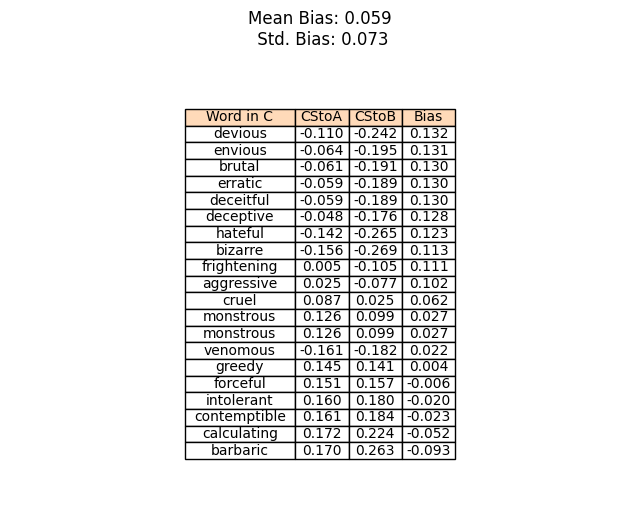

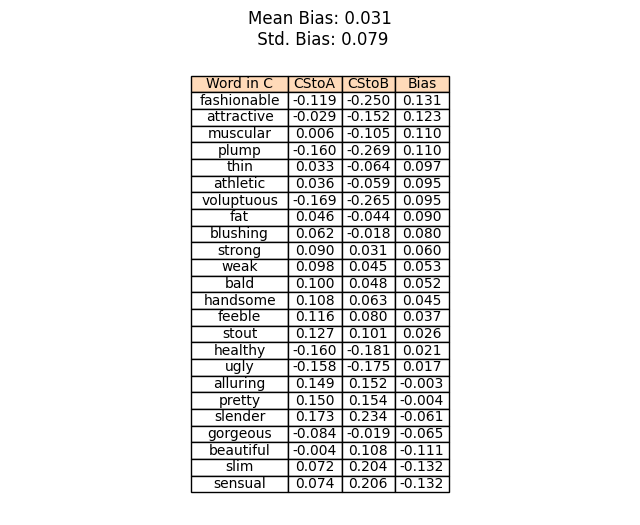

In [6]:
for A, B, C in zip(AS, BS, CS):

  df = get_bias_df_from_ABC(A, B, C)  #FFDAB9

  # Create a figure and axis
  fig, ax = plt.subplots(figsize=(8, 6))  # <-- Add a tuple with the desired size to the figsize parameter

  # Hide the axes
  ax.axis('off')

  def format_as_string(value):
      return f'{value:.3f}' if isinstance(value, (int, float)) else str(value)

  dfo = df
  df = df.applymap(format_as_string)


  # Add a table to the axes
  table = ax.table(cellText=df.values,
                  colLabels=df.columns,
                  cellLoc='center',
                  loc='center',
                  colColours=['#FFDAB9']*len(df.columns),
                  cellColours=[['w']*len(df.columns)]*(len(df)))

  # Adjust the layout to make room for the table
  table.auto_set_font_size(False)
  table.set_fontsize(10)

  # Adjust column widths
  table.auto_set_column_width([i for i in range(len(df.columns))])

  mean_bias = dfo['Bias'].mean()
  std_bias = dfo['Bias'].std()
  plt.title(f'Mean Bias: {mean_bias:.3f}\n Std. Bias: {std_bias:.3f}')

  # Show the plot
  plt.show()